### Citibike Analysis

In [205]:
# import dependencies
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.neighbors import DistanceMetric
from math import radians
from geopy import distance

In [206]:
# filepath to input data
filename = '../Resources/data/202109-citibike-tripdata.csv'
# filepath to output data
fileout_clean = '../Resources/data/202109-citibike-tripdata-clean.csv'
fileout_dock = '../Resources/data/202109-citibike-dock.csv'
fileout_rebalance = '../Resources/data/202109-citibike-rebalance.csv'
fileout_stations = '../Resources/data/202109-citibike-stations.csv'


In [207]:
# read in table
bike_data = pd.read_csv(filename)

C:\Users\kathe\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [208]:
bike_data = bike_data.drop_duplicates()

In [209]:
# after preliminary exploration of dataset, decided to drop rows with null values
bike_data = bike_data.dropna()

In [210]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264870 entries, 0 to 3280220
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    float64
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(5), object(8)
memory usage: 348.7+ MB


In [211]:
bike_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,22C33F42C6A0E28E,classic_bike,2021-09-01 10:26:45,2021-09-01 10:43:23,Central Park West & W 72 St,7141.07,E 51 St & 1 Ave,6532.06,40.775794,-73.976206,40.754557,-73.965930,member
2,9C43CF6A07DACBC6,classic_bike,2021-09-06 17:07:40,2021-09-06 17:34:44,Fulton St & Broadway,5175.08,Jay St & Tech Pl,4710.06,40.711066,-74.009447,40.695065,-73.987167,casual
3,253A1A5B20CC78EE,classic_bike,2021-09-28 16:53:43,2021-09-28 17:03:00,West Drive & Prospect Park West,3651.04,Ocean Pkwy & Church Ave,3125.09,40.661063,-73.979453,40.644719,-73.974515,member
4,5E8F164D6798CEFA,classic_bike,2021-09-19 09:37:47,2021-09-19 09:53:42,Lorimer St & Broadway,4965.01,Jay St & Tech Pl,4710.06,40.704118,-73.948186,40.695065,-73.987167,member
5,0702265BE26C21F3,classic_bike,2021-09-23 09:35:32,2021-09-23 09:38:00,William St & Pine St,5065.12,Fulton St & Pearl St,5024.09,40.707179,-74.008873,40.707722,-74.004386,member


In [212]:
bike_data.isna().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [213]:
bike_data.iloc[:, 1].unique()

array(['classic_bike', 'docked_bike'], dtype=object)

In [214]:
bike_data.iloc[:, 12].unique()

array(['member', 'casual'], dtype=object)

In [215]:
# end station ids are mix of numeric and string.  convert all to string
bike_data.end_station_id = bike_data.end_station_id.astype(str)
bike_data.start_station_id = bike_data.start_station_id.astype(str)

In [216]:
no_stations_end = len(bike_data.end_station_id.unique())
no_stations_end


1595

In [217]:
no_stations_start = len(bike_data.start_station_id.unique())
no_stations_start

1488

In [218]:
# find difference between start and end stations
li1=bike_data.start_station_id.unique()
li2=bike_data.end_station_id.unique()
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

li3 = Diff(li1, li2)
print(li3)

['7849.1', '6948.10', '7932.10', '6364.10', 'JC057', 'JC003', '7845.10', '5247.10', '4095.10', '5854.10', '8249.10', 'HB202', 'SYS033', '6659.10', '6923.20', '5065.10', 'HB203', '7888.10', 'JC104', '5669.10', '4632.10', '7849.10', '7388.10', '8416.10', '7627.10', '7781.10', 'JC038', '8358.10', '8104.10', 'HB404', '5470.10', 'JC072', '4137.10', 'JC013', '6839.10', '5553.10', '5506.10', '5342.10', '5379.10', '8153.10', 'JC052', '7669.10', '5785.10', '7293.10', '7835.10', '4994.10', 'SYS035', '7111.10', 'JC106', '7152.10', 'JC081', 'HB201', 'JC095', '6596.10', '6098.10', '7948.10', '7360.10', 'HB401', 'JC008', '7188.10', '6313.10', '5872.10', 'JC006', '4455.10', '4798.10', '5359.10', 'HB102', '4483.10', '7372.10', 'JC055', '6667.10', 'HB603', 'JC014', 'HB103', '4110.10', '6960.10', 'SYS014', 'JC002', '5332.10', '6893.10', 'HB506', 'JC011', 'JC059', '4404.10', '4249.10', '7596.10', '6498.10', '8049.10', '8107.10', 'JC056', '3834.10', '7910.10', '3981.10', '7756.10', '4157.10', 'HB304', 'JC

In [219]:
# find difference between start and end stations names
li1=bike_data.start_station_name.unique()
li2=bike_data.end_station_name.unique()
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

li3 = Diff(li1, li2)
print(li3)

['Grand St', 'Brunswick & 6th', 'McGinley Square', '14 St Ferry - 14 St & Shipyard Ln', 'NYCBS DEPOT - DELANCEY', 'Paulus Hook', 'Pier 40 X2', 'Morris Canal', 'Madison St & 1 St', 'City Hall', 'Church Sq Park - 5 St & Park Ave', 'Liberty Light Rail', 'Marin Light Rail', '8 St & Washington St', 'JC Medical Center', '12 St & Sinatra Dr N', 'Mama Johnson Field - 4 St & Jackson St', 'Bergen Ave', 'Pier 40 Dock Station', 'Manila & 1st', 'Hoboken Terminal - River St & Hudson Pl', 'Columbus Drive', 'Riverview Park', 'Bloomfield St & 15 St', '7 St & Monroe St', 'Newport Pkwy', 'South Waterfront Walkway - Sinatra Dr & 1 St', 'Columbus Dr at Exchange Pl', 'Essex Light Rail', 'Warren St', 'Grand St & 14 St', 'Harborside', '11 St & Washington St', 'Sip Ave', 'Southwest Park - Jackson St & Observer Hwy', 'Heights Elevator']


In [220]:
# convert times to datetime and calculate trip duration
bike_data['start'] = bike_data.started_at.astype('datetime64[ns]')
bike_data['end'] = bike_data.ended_at.astype('datetime64[ns]')
bike_data['duration'] = (bike_data.end - bike_data.start) / pd.Timedelta(minutes=1)

In [222]:
bike_data.loc[bike_data.duration < 0]



,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start,end,duration
2246,95140F55A2271475,classic_bike,2021-09-29 16:51:29,2021-09-29 16:46:30,8 Ave & W 38 St,6526.05,8 Ave & W 38 St,6526.05,40.754610,-73.991770,40.754610,-73.991770,casual,2021-09-29 16:51:29,2021-09-29 16:46:30,-4.983333
21912,C4DA56DB93622926,classic_bike,2021-09-29 12:35:38,2021-09-29 12:30:53,E 32 St & Park Ave,6280.12,E 32 St & Park Ave,6280.12,40.745712,-73.981948,40.745712,-73.981948,member,2021-09-29 12:35:38,2021-09-29 12:30:53,-4.750000
32011,3489D5075B040E7E,classic_bike,2021-09-29 18:55:32,2021-09-29 18:55:30,Rivington St & Ridge St,5406.02,Rivington St & Ridge St,5406.02,40.718502,-73.983299,40.718502,-73.983299,member,2021-09-29 18:55:32,2021-09-29 18:55:30,-0.033333
43076,B20CAB7799F13747,classic_bike,2021-09-29 18:39:30,2021-09-29 18:39:21,E 2 St & Avenue B,5515.02,E 2 St & Avenue B,5515.02,40.722174,-73.983688,40.722174,-73.983688,casual,2021-09-29 18:39:30,2021-09-29 18:39:21,-0.150000
43890,801C6F4B5FEB23D4,classic_bike,2021-09-29 16:35:27,2021-09-29 16:24:10,E 16 St & Irving Pl,5938.11,E 16 St & Irving Pl,5938.11,40.735367,-73.987974,40.735367,-73.987974,member,2021-09-29 16:35:27,2021-09-29 16:24:10,-11.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236415,C4CE17D8063B48F3,classic_bike,2021-09-29 17:46:19,2021-09-29 17:46:16,West End Ave & W 60 St,7059.08,West End Ave & W 60 St,7059.08,40.772370,-73.990050,40.772370,-73.990050,casual,2021-09-29 17:46:19,2021-09-29 17:46:16,-0.050000
3237195,E8B7650D0C60D943,classic_bike,2021-09-29 18:28:07,2021-09-29 18:25:12,West End Ave & W 60 St,7059.08,West End Ave & W 60 St,7059.08,40.772370,-73.990050,40.772370,-73.990050,member,2021-09-29 18:28:07,2021-09-29 18:25:12,-2.916667
3260672,F1890B88EF00C349,classic_bike,2021-09-29 18:51:47,2021-09-29 18:51:46,10 Ave & W 28 St,6459.04,10 Ave & W 28 St,6459.04,40.750664,-74.001768,40.750664,-74.001768,member,2021-09-29 18:51:47,2021-09-29 18:51:46,-0.016667
3263018,7394B85BB00FF969,classic_bike,2021-09-29 17:06:01,2021-09-29 16:58:36,10 Ave & W 28 St,6459.04,10 Ave & W 28 St,6459.04,40.750664,-74.001768,40.750664,-74.001768,casual,2021-09-29 17:06:01,2021-09-29 16:58:36,-7.416667


In [224]:
# remove rows with duration < 0
bike_data = bike_data.loc[bike_data.duration > 0]

In [226]:
bike_data.groupby("rideable_type").count()

# electric_bike trips are not real and were dropped from dataset when removing null rows#
# remove electric bike trips from dataset
bike_data = bike_data[bike_data.rideable_type != "electric_bike"]

In [227]:
# keep only rows where start station id and end station id are numeric
# replaced = bike_data.end_station_id.str.replace(".", "", 1)
# check = replaced.str.isdigit()

# don't need this anymore as station id method changed
# bike_data.loc[bike_data.end_station_id.astype(str).str.replace(".","",1).str.isdigit()]
# bike_data.loc[~bike_data.end_station_id.astype(str).str.replace(".","",1).str.isdigit()]

In [228]:
# calculate trip distance

# haversine function taken from this page https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    mi = 3798 * c #6367 for km
    return mi

bike_data['distance_mi'] = haversine_np(bike_data["start_lng"],bike_data["start_lat"],bike_data["end_lng"],bike_data["end_lat"]).round(2)




In [229]:
# drop start at and end at columns
bike_data = bike_data.drop(columns = ["started_at", "ended_at"], axis = 1)


In [230]:
# separate by bike type
classic = bike_data[bike_data.rideable_type == "classic_bike"]
docked = bike_data[bike_data.rideable_type == "docked_bike"]

In [231]:
docked = docked[['ride_id', 'start_station_name', 'start_station_id',
       'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
       'end_lat', 'end_lng',  'start', 'end', 'duration',
       ]]
docked.head()

,ride_id,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,start,end,duration
196,3841A1A8FD3FEA70,Fulton St & Broadway,5175.08,10 Ave & W 14 St,6157.04,40.711066,-74.009447,40.741982,-74.008316,2021-09-27 15:03:14,2021-09-27 15:29:31,26.283333
253,50B637E0507DE505,Fulton St & Broadway,5175.08,Broadway & Battery Pl,4962.01,40.711066,-74.009447,40.704633,-74.013617,2021-09-13 11:40:05,2021-09-13 12:17:45,37.666667
337,61D8BC2A874D9D4D,Concourse Village West & E 156 St,7962.01,Freeman St & Reverend James A Polite Ave,8080.01,40.823162,-73.923267,40.830529,-73.894717,2021-09-21 18:24:25,2021-09-21 18:48:31,24.100000
462,1C0ACD6BE36AAF4A,West Drive & Prospect Park West,3651.04,Carroll St & Smith St,4225.14,40.661063,-73.979453,40.680611,-73.994758,2021-09-04 13:02:54,2021-09-04 13:18:16,15.366667
920,629C582C43EFFE3C,West Drive & Prospect Park West,3651.04,Prospect Park West & 8 St,3722.04,40.661063,-73.979453,40.665147,-73.976376,2021-09-16 03:44:18,2021-09-16 03:49:49,5.516667


In [232]:
# extract date portion of datetime
classic["start_date"] = pd.to_datetime(classic.start).dt.normalize()



C:\Users\kathe\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [233]:
classic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3231239 entries, 0 to 3280220
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   start_station_name  object        
 3   start_station_id    object        
 4   end_station_name    object        
 5   end_station_id      object        
 6   start_lat           float64       
 7   start_lng           float64       
 8   end_lat             float64       
 9   end_lng             float64       
 10  member_casual       object        
 11  start               datetime64[ns]
 12  end                 datetime64[ns]
 13  duration            float64       
 14  distance_mi         float64       
 15  start_date          datetime64[ns]
dtypes: datetime64[ns](3), float64(6), object(7)
memory usage: 419.1+ MB


In [234]:
# count number of starts from each station for each day
classic_starts = classic.groupby(["start_date", "start_station_name"])["ride_id"].count()
classic_starts = classic_starts.reset_index(["start_date", "start_station_name"])
classic_starts = classic_starts.rename(columns={"start_date":"date", "start_station_name":"station_name", "ride_id":"count_starts"})


In [235]:
# count number of ends each station for each day
classic_ends = classic.groupby(["start_date", "end_station_name"])["ride_id"].count()
classic_ends = classic_ends.reset_index(["start_date", "end_station_name"])
classic_ends = classic_ends.rename(columns={"start_date":"date", "end_station_name":"station_name", "ride_id":"count_ends"})

In [236]:

classic_ends

,date,station_name,count_ends
0,2021-09-01,1 Ave & E 110 St,48
1,2021-09-01,1 Ave & E 16 St,165
2,2021-09-01,1 Ave & E 18 St,126
3,2021-09-01,1 Ave & E 30 St,80
4,2021-09-01,1 Ave & E 39 St,126
...,...,...,...
43711,2021-09-30,Wyckoff Av & Stanhope St,59
43712,2021-09-30,Wyckoff Ave & Gates Ave,46
43713,2021-09-30,Wyckoff St & Nevins St,22
43714,2021-09-30,Wythe Ave & Metropolitan Ave,219


In [237]:
# merge the above 2 tables
rebalances = pd.merge(classic_starts, classic_ends, how = "outer", left_on=(["date", "station_name"]), right_on=(["date", "station_name"]))
rebalances = rebalances.fillna(0)
rebalances["count_rebalance"] = rebalances.count_ends - rebalances.count_starts
# a negative rebalance means that bikes need to be replaced, a positive rebalance means that bikes need to be removed

In [238]:
rebalances.head()

,date,station_name,count_starts,count_ends,count_rebalance
0,2021-09-01,1 Ave & E 110 St,48.0,48.0,0.0
1,2021-09-01,1 Ave & E 16 St,185.0,165.0,-20.0
2,2021-09-01,1 Ave & E 18 St,144.0,126.0,-18.0
3,2021-09-01,1 Ave & E 30 St,83.0,80.0,-3.0
4,2021-09-01,1 Ave & E 39 St,125.0,126.0,1.0


In [239]:
bike_data.columns

Index(['ride_id', 'rideable_type', 'start_station_name', 'start_station_id',
       'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
       'end_lat', 'end_lng', 'member_casual', 'start', 'end', 'duration',
       'distance_mi'],
      dtype='object')

In [240]:
# extract station data
start_stations = bike_data[['start_station_name', 'start_station_id',
        'start_lat', 'start_lng']].drop_duplicates()
end_stations = bike_data[['end_station_name', 'end_station_id',
        'end_lat', 'end_lng']].drop_duplicates()
start_stations = start_stations.rename(columns = ({'start_station_name':'station_name', 'start_station_id':'station_id',
        'start_lat':'lat', 'start_lng':'lng'}))
end_stations = end_stations.rename(columns = ({'end_station_name':'station_name', 'end_station_id':'station_id',
        'end_lat':'lat', 'end_lng':'lng'}))



In [241]:
stations = pd.concat([start_stations, end_stations], ignore_index = True)
stations = stations.drop_duplicates(subset = "station_id")

In [242]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 0 to 4518
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  1596 non-null   object 
 1   station_id    1596 non-null   object 
 2   lat           1596 non-null   float64
 3   lng           1596 non-null   float64
dtypes: float64(2), object(2)
memory usage: 62.3+ KB


In [243]:
# export tables
# bike_data.to_csv(fileout_clean, index=False)
docked.to_csv(fileout_dock, index=False)
rebalances.to_csv(fileout_rebalance, index=False)
stations.to_csv(fileout_stations, index=False)

<AxesSubplot:ylabel='Frequency'>

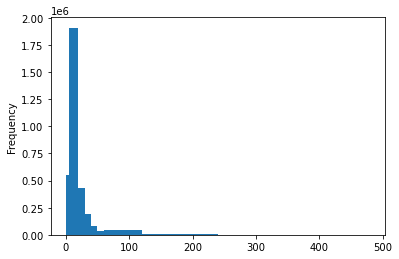

In [249]:
bike_data.duration.plot.hist(bins = [0,5,20, 30, 40, 50, 60, 120,240,480])